In [134]:
#!pip install shap
#!pip install sklearn
import pandas as pd
import numpy as np
import shap
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import eig
import datetime
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from numpy.linalg import eig
from sklearn.model_selection import train_test_split

In [2]:
#INITIAL EDA FEATURE RECODE

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='action_type', ylabel='Density'>

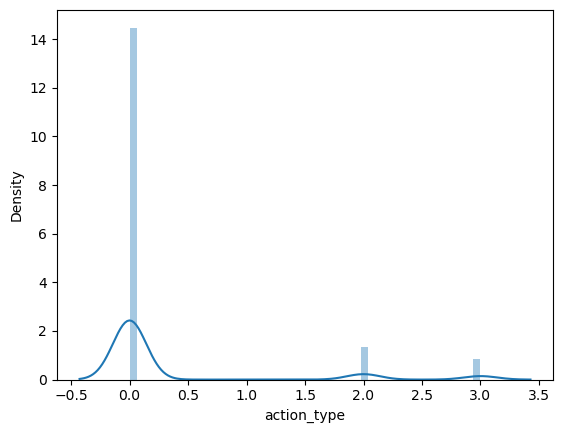

In [5]:
user_log = pd.read_csv('./use_data/user_log_format1[161-320].csv', iterator=True, chunksize=10000)
user_log = pd.concat(user_log, ignore_index=True)
sns.distplot(user_log['action_type'], kde=True, hist=True)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='cat_id', ylabel='Density'>

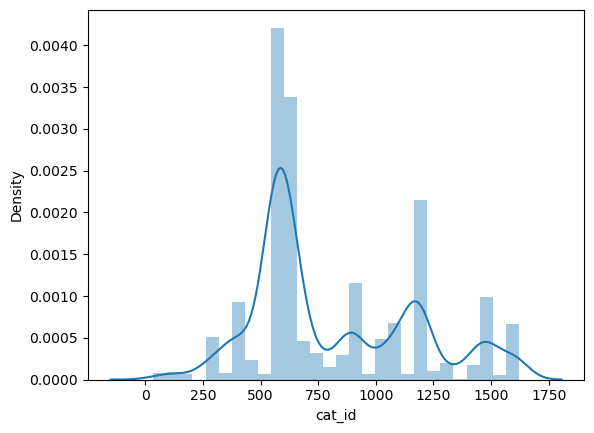

In [6]:
sns.distplot(user_log['cat_id'],hist=True)

In [7]:
user_log['time_str']= user_log['time_stamp'].astype('str')
user_log['Day']=user_log['time_stamp']%100
user_log['Month']=(user_log['time_stamp']-user_log['Day'])/100
user_log['Month']= user_log['Month'].astype('int')
print(user_log.head())

   user_id  item_id  cat_id  seller_id  brand_id  time_stamp  action_type  \
0   149002      282     885       3791    1500.0        1111            0   
1   149002      282     885       3791    1500.0        1107            0   
2   109881      230     629          1    1662.0         820            0   
3   109881      230     629          1    1662.0         820            0   
4   109881      230     629          1    1662.0         820            0   

  time_str  Day  Month  
0     1111   11     11  
1     1107    7     11  
2      820   20      8  
3      820   20      8  
4      820   20      8  


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='Month', ylabel='Density'>

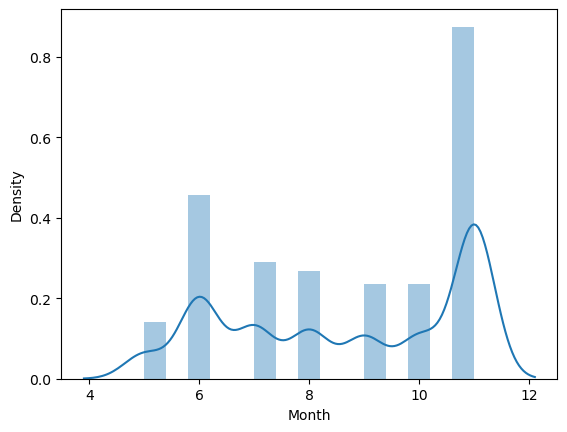

In [8]:
sns.distplot(user_log['Month'],hist=True)

In [10]:
#user_id and category
user_cat_count= user_log.groupby(['user_id','cat_id']).size()
user_cat_click_count = user_log.groupby(['user_id','cat_id','action_type']).size().to_frame()
user_cat_click_count.head()

,,,0
user_id,cat_id,action_type,
297,614,0,1
867,1181,0,1
997,1467,0,1
1076,559,0,1
1295,559,0,1


In [11]:
#category action
cat_click_count = user_log.groupby(['cat_id','action_type']).size()
cat_click_count.head()

cat_id  action_type
35      0               7
71      0              17
        2               3
103     0               2
        2               1
dtype: int64

In [12]:
#brand action
brand_click_count = user_log.groupby(['brand_id','action_type']).size()
brand_click_count.head()

brand_id  action_type
68.0      0              18
69.0      0              24
          2               1
99.0      0              22
          2               1
dtype: int64

In [13]:
#merchandise action
mer_click_count = user_log.groupby(['item_id','action_type']).size()
mer_click_count.head()

item_id  action_type
161      0              4
162      0              2
163      0              6
         3              2
164      0              3
dtype: int64

In [14]:
click_activity_percent = user_log['action_type'].value_counts(normalize=True)*100
dict_user_cat = dict(zip(user_log['user_id'],user_log['cat_id']))
dict_user_brand = dict(zip(user_log['user_id'],user_log['brand_id']))
dict_user_merch = dict(zip(user_log['user_id'],user_log['item_id']))
#user category click activity
user_cat_total = user_log.groupby(['user_id','cat_id'])['action_type'].count().to_frame()
user_cat_total.head()

,,action_type
user_id,cat_id,
297,614,1
867,1181,1
997,1467,1
1076,559,1
1295,559,1


In [15]:
user_cat_total.columns = ['count total']
user_cat_total.head()

,,count total
user_id,cat_id,
297,614,1
867,1181,1
997,1467,1
1076,559,1
1295,559,1


In [16]:
user_cat_click_count.columns = ['size']
user_cat_click_count.head()

,,,size
user_id,cat_id,action_type,
297,614,0,1
867,1181,0,1
997,1467,0,1
1076,559,0,1
1295,559,0,1


In [21]:
user_cat_activity = user_cat_total.join(user_cat_click_count,how='left')
user_cat_activity['percentage'] = user_cat_activity['size']/user_cat_activity['count total']
user_cat_activity.head()

,,,count total,size,percentage
user_id,cat_id,action_type,,,
297,614,0,1,1,1.0
867,1181,0,1,1,1.0
997,1467,0,1,1,1.0
1076,559,0,1,1,1.0
1295,559,0,1,1,1.0


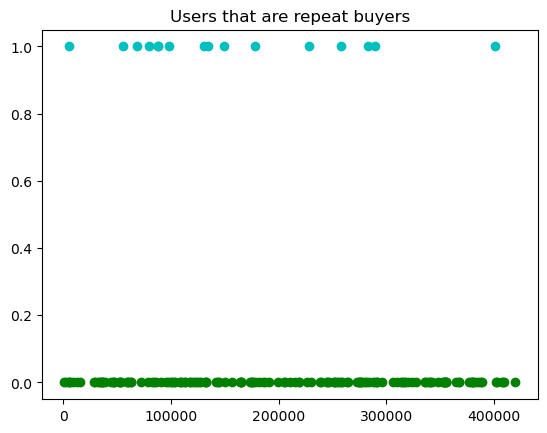

In [25]:
train_format = pd.read_csv('../data_format1/use_data/train_format1[161-320].csv', iterator=True, chunksize=10000)
train_format = pd.concat(train_format, ignore_index=True)

user_label = {}
# go through user_seller sub-dataframe and split entries by user_id:seller_id
for index, row in train_format.iterrows():
    if row['user_id'] not in user_label:
        # there may be multiple entries, so default with an empty list
        user_label[row["user_id"]] = [] 
    user_label[row["user_id"]] = row["label"]
repeat_buyers = dict((k, v) for k, v in user_label.items() if v > 0)
non_repeat_buyers = dict((k, v) for k, v in user_label.items() if v == 0)

lists = sorted(repeat_buyers.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.scatter(x, y, label="repeat buyers",color="c")
lists2 = sorted(non_repeat_buyers.items()) # sorted by key, return a list of tuples
x2, y2 = zip(*lists2) # unpack a list of pairs into two tuples
plt.scatter(x2, y2, label="not repeat buyers",color="g")
plt.title('Users that are repeat buyers')
plt.show()

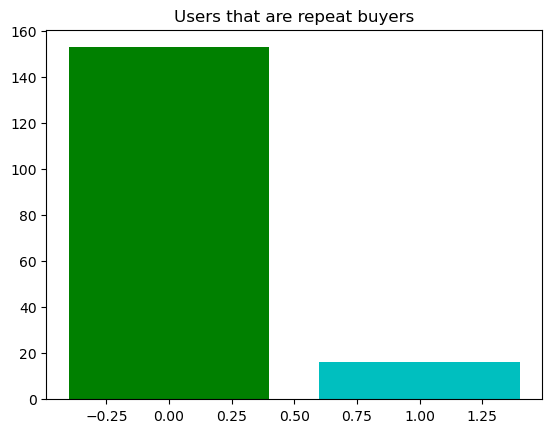

In [26]:
lists = sorted(repeat_buyers.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.bar(y, len(x), label="repeat buyers",color="c")
lists2 = sorted(non_repeat_buyers.items()) # sorted by key, return a list of tuples
x2, y2 = zip(*lists2) # unpack a list of pairs into two tuples
plt.bar(y2, len(x2), label="not repeat buyers",color="g")
plt.title('Users that are repeat buyers')
plt.show()

In [33]:
#USER LOG AND INFO VISUALIZATION

In [34]:
df = pd.read_csv("./use_data/user_info_format1[161-320].csv")
df = df.drop('user_id', axis=1)
df_female = df.loc[df['gender'] == 0].drop(['gender'], axis=1).to_numpy()
df_male = df.loc[df['gender'] == 1].drop(['gender'], axis=1).to_numpy()
df_age_1 = df.loc[df['age_range'] == 1.0].drop(['age_range'], axis=1).to_numpy()
df_age_2 = df.loc[df['age_range'] == 2.0].drop(['age_range'], axis=1).to_numpy()
df_age_3 = df.loc[df['age_range'] == 3.0].drop(['age_range'], axis=1).to_numpy()
df_age_4 = df.loc[df['age_range'] == 4.0].drop(['age_range'], axis=1).to_numpy()
df_age_5 = df.loc[df['age_range'] == 5.0].drop(['age_range'], axis=1).to_numpy()
df_age_6 = df.loc[df['age_range'] == 6.0].drop(['age_range'], axis=1).to_numpy()
df_age_7 = df.loc[df['age_range'] == 7.0]
df_age_8 = df.loc[df['age_range'] == 8.0]
df_age_7 = pd.concat([df_age_7,df_age_8]).drop(['age_range'], axis=1).to_numpy()

df

,age_range,gender
0,5.0,2.0
1,5.0,1.0
2,4.0,0.0
3,6.0,0.0
4,4.0,1.0
...,...,...
3666,3.0,0.0
3667,0.0,0.0
3668,3.0,1.0
3669,0.0,0.0


In [35]:
def count(df):
    keys = np.unique(df)
    count = {}
    for key in keys:
        count[key] = np.count_nonzero(df == key)
    return count

<BarContainer object of 8 artists>

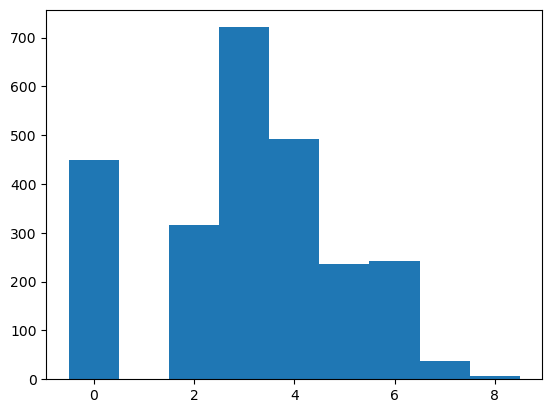

In [36]:
female_count = count(df_female)
plt.bar(female_count.keys(),female_count.values(),width=1)

<BarContainer object of 9 artists>

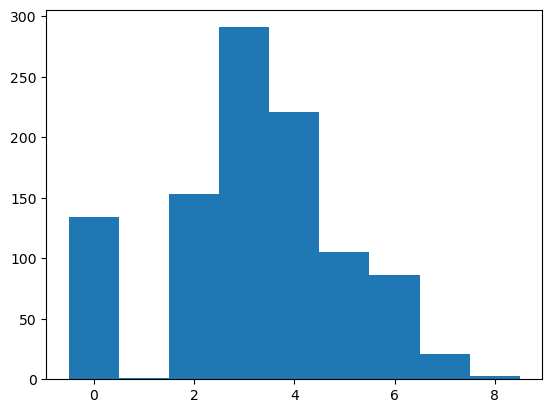

In [37]:
male_count = count(df_male)
plt.bar(male_count.keys(),male_count.values(),width=1)

<BarContainer object of 1 artists>

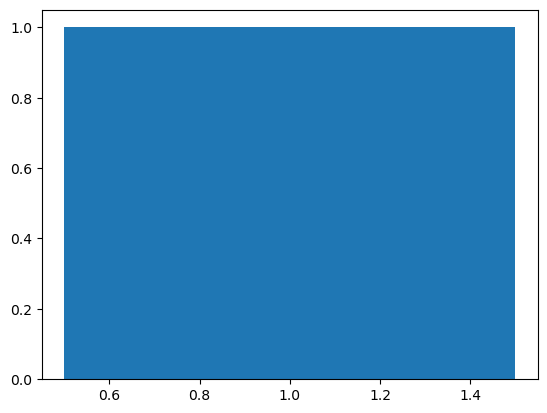

In [38]:
df_age_1 = count(df_age_1)
plt.bar(df_age_1.keys(),df_age_1.values(),width=1)

<BarContainer object of 4 artists>

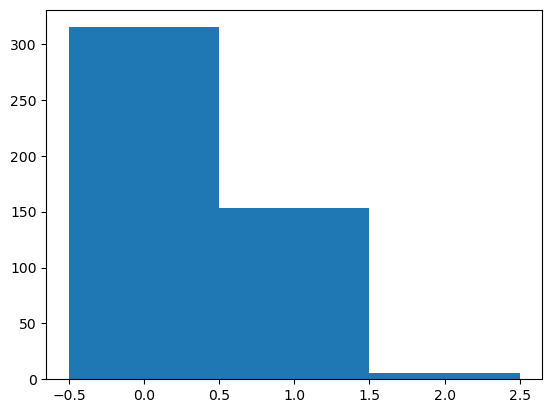

In [39]:
df_age_2 = count(df_age_2)
plt.bar(df_age_2.keys(),df_age_2.values(),width=1)

<BarContainer object of 4 artists>

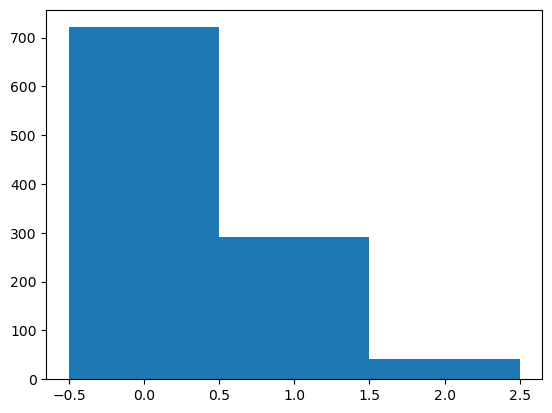

In [40]:
df_age_3 = count(df_age_3)
plt.bar(df_age_3.keys(),df_age_3.values(),width=1)

<BarContainer object of 3 artists>

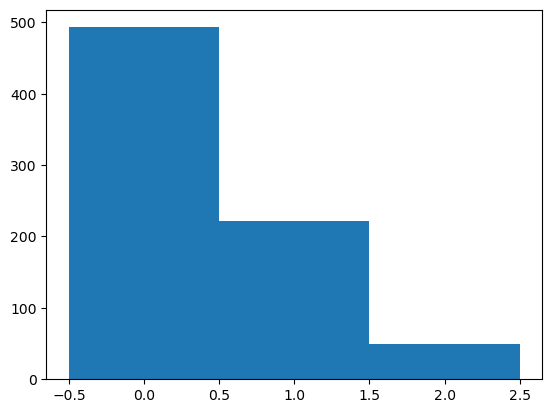

In [41]:
df_age_4 = count(df_age_4)
plt.bar(df_age_4.keys(),df_age_4.values(),width=1)

<BarContainer object of 3 artists>

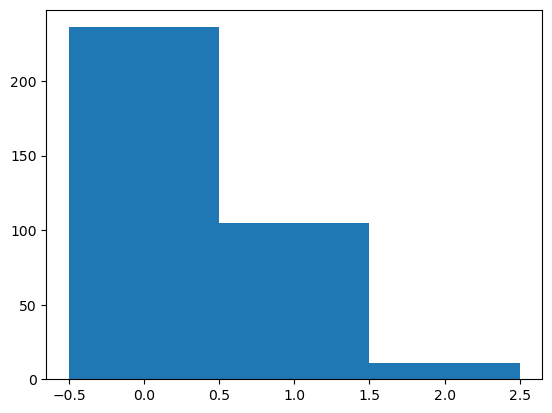

In [42]:
df_age_5 = count(df_age_5)
plt.bar(df_age_5.keys(),df_age_5.values(),width=1)

<BarContainer object of 4 artists>

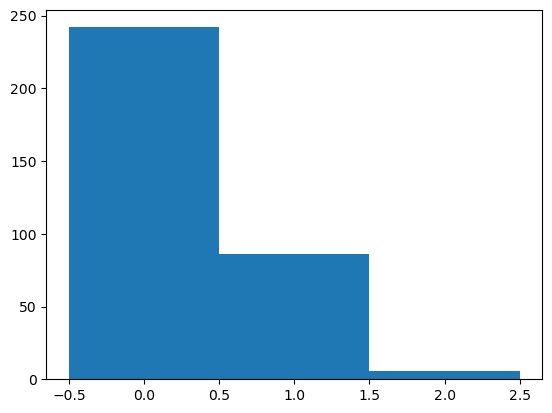

In [43]:
df_age_6 = count(df_age_6)
plt.bar(df_age_6.keys(),df_age_6.values(),width=1)

<BarContainer object of 3 artists>

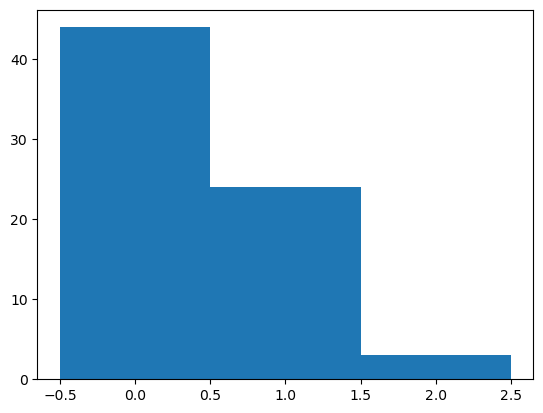

In [44]:
df_age_7 = count(df_age_7)
plt.bar(df_age_7.keys(),df_age_7.values(),width=1)

In [45]:
df2 = pd.read_csv("./use_data/user_log_format1[161-320].csv")

<AxesSubplot:ylabel='Frequency'>

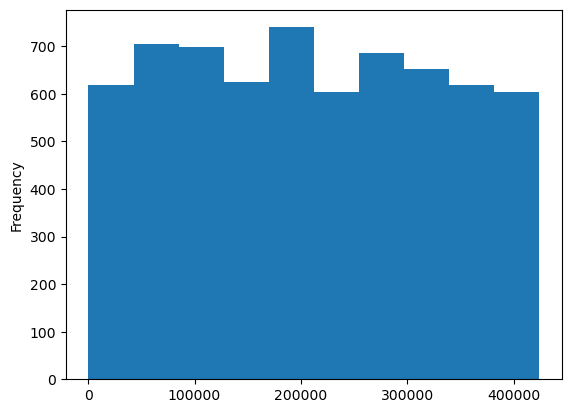

In [46]:
df2['user_id'].plot(kind="hist")

<BarContainer object of 155 artists>

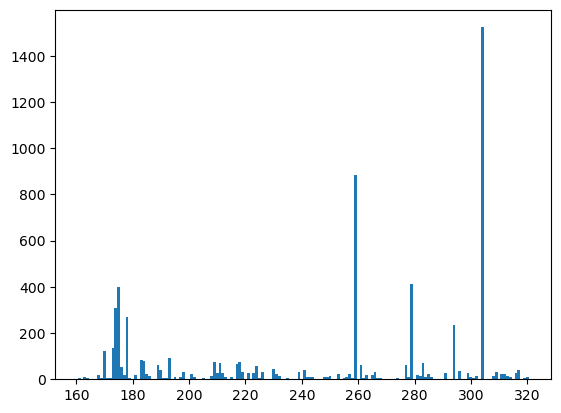

In [47]:
item_id = df2['item_id']
item_id.to_numpy()
item_id_count = count(item_id)
plt.bar(item_id_count.keys(),item_id_count.values(),width=1)

<BarContainer object of 88 artists>

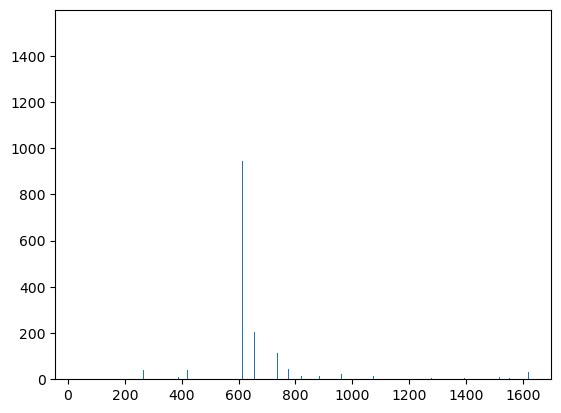

In [48]:
cat_id = df2['cat_id']
cat_id.to_numpy()
cat_id_count = count(cat_id)
plt.bar(cat_id_count.keys(),cat_id_count.values(),width=1)

<BarContainer object of 149 artists>

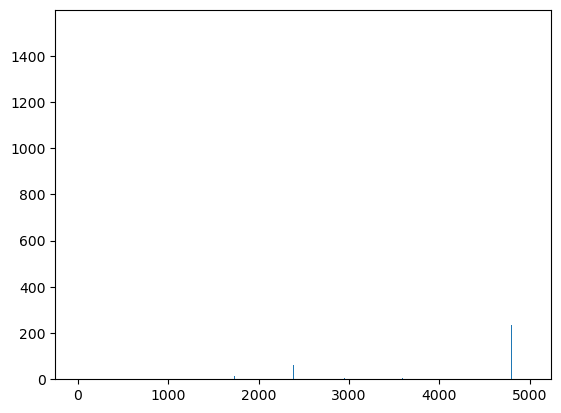

In [49]:
seller_id = df2['seller_id']
seller_id.to_numpy()
seller_id_count = count(seller_id)
plt.bar(seller_id_count.keys(),seller_id_count.values(),width=1)

<BarContainer object of 151 artists>

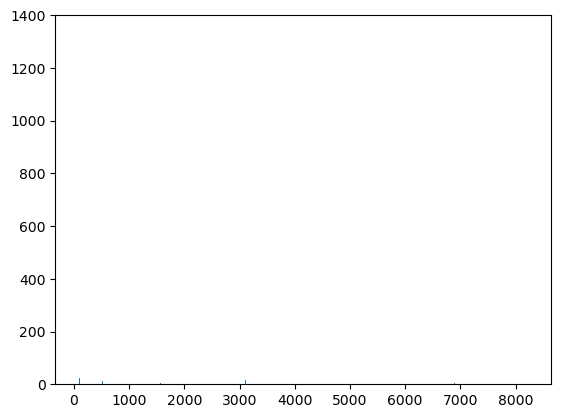

In [50]:
brand_id = df2['brand_id']
brand_id.to_numpy()
brand_id_count = count(brand_id)
plt.bar(brand_id_count.keys(),brand_id_count.values(),width=1)

<BarContainer object of 4 artists>

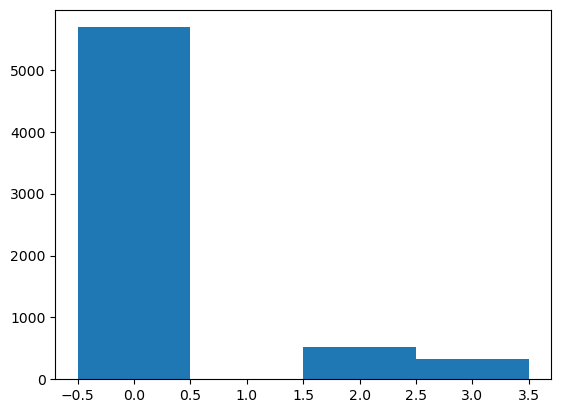

In [53]:
action_type = df2['action_type']
action_type.to_numpy()
action_type_count = count(action_type)
plt.bar(action_type_count.keys(),action_type_count.values(),width=1)

<BarContainer object of 184 artists>

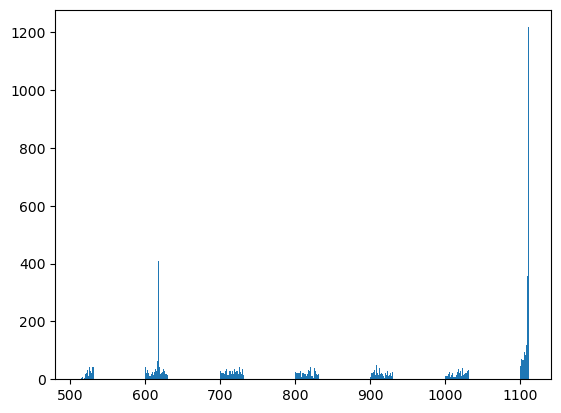

In [52]:
time_stamp = df2['time_stamp']
time_stamp.to_numpy()
time_stamp_count = count(time_stamp)
plt.bar(time_stamp_count.keys(),time_stamp_count.values(),width=1)

In [ ]:
#TIMESTAMP VS ACTION

In [54]:
df = pd.read_csv("use_data/merged_dataset.csv")
df = df.drop('brand_id', axis=1)
df = df.drop('age_range', axis=1)
df = df.drop('gender', axis=1)
#Split between IDs and Data
df_ids = df.iloc[:, :4]
df_vals = df.iloc[:, 4:]
df_vals

,time_stamp,action_type
0,1111,0
1,1107,0
2,820,0
3,820,0
4,820,0
...,...,...
6544,1111,0
6545,1111,0
6546,1110,0
6547,1101,0


<AxesSubplot:xlabel='time_stamp', ylabel='action_type'>

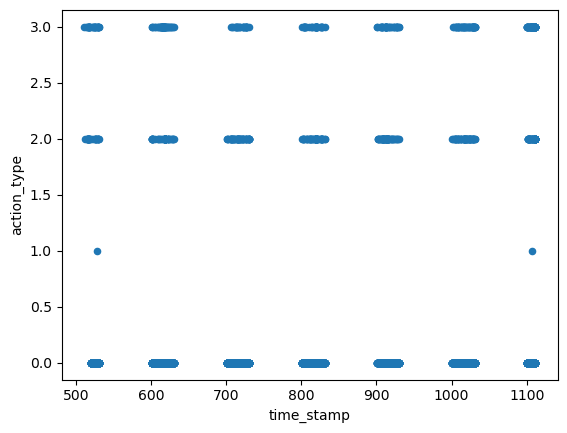

In [55]:
df_vals.plot(kind = 'scatter', x = 'time_stamp', y = 'action_type')

<AxesSubplot:ylabel='Frequency'>

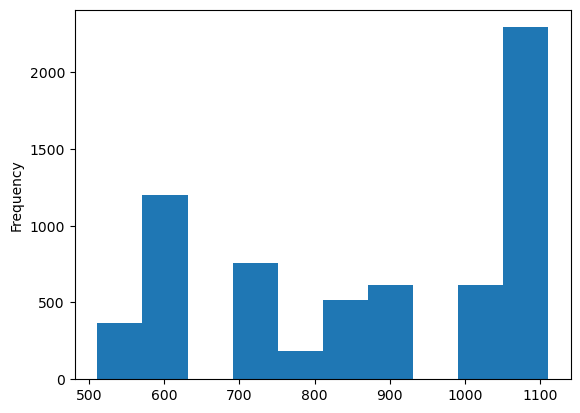

In [56]:
df_vals['time_stamp'].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

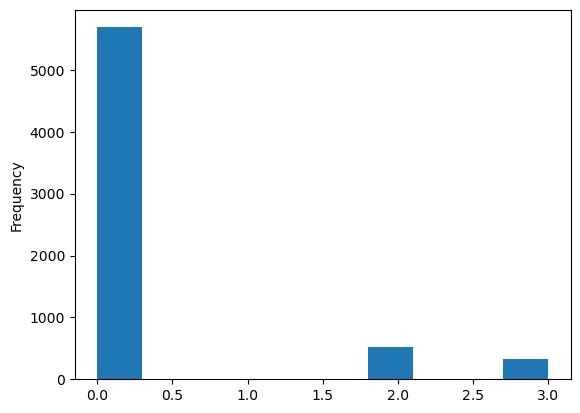

In [57]:
df_vals['action_type'].plot(kind="hist")

In [ ]:
#DATA FILTERING

In [29]:
df = pd.read_csv("use_data/user_log_format1[161-320].csv")
df2 = pd.read_csv("full_data/user_info_format1.csv")
file_name = 'user_info' # user_info_format1.csv

# the unique list of users from the above dataframe
users = df['user_id'].unique().tolist()

with open(f'use_data/{file_name}_format1[161-320].csv', 'w') as f:
    with open(f'full_data/{file_name}_format1.csv', 'r') as d_f:
        f.write(d_f.readline()) # read the first line (column names)

        for line in d_f.readlines():
            items = line.split(',')
            
            # add if items[0] is in users (which is a unique list)
            if (int(items[0]) in users): 
                f.write(line)

user_seller = df[["user_id", "seller_id"]]

us_dict = {}

# go through user_seller sub-dataframe and split entries by user_id:seller_id
for index, row in user_seller.iterrows():
    if row['user_id'] not in us_dict:
        # there may be multiple entries, so default with an empty list
        us_dict[row["user_id"]] = [] 
    us_dict[row["user_id"]].append(row["seller_id"])
    
for k,v in us_dict.items():
    us_dict[k] = list(set(v)) # make each value list unique
us_dict

{149002: [3791],
 109881: [1],
 142526: [2781],
 123526: [3989],
 359170: [3096],
 46520: [158],
 346053: [1765],
 355049: [3989],
 47958: [4257],
 50931: [4955],
 125098: [3989],
 365160: [3828],
 339574: [3101],
 14747: [3323],
 382864: [3989],
 375786: [4257],
 266494: [3083],
 267067: [1913],
 143871: [3989],
 379824: [145],
 59889: [3989],
 188455: [4798],
 248722: [1],
 97560: [3989],
 104634: [834],
 7692: [1641],
 331906: [1641],
 305119: [158],
 227909: [4282],
 345174: [831],
 114906: [4257],
 104420: [637],
 47143: [3989],
 243241: [1641],
 48664: [3989],
 389693: [3989],
 266355: [4257],
 237879: [4257],
 149697: [3989],
 44152: [2623],
 141307: [4760],
 337965: [3989],
 329315: [4257],
 43299: [2642],
 167621: [3989],
 323238: [637],
 203088: [3989],
 104074: [3989],
 13603: [4257],
 79000: [3989],
 182925: [3989],
 100396: [1641],
 362703: [4798],
 252255: [4760],
 324321: [4321],
 358906: [4760],
 266517: [4257],
 96868: [3828],
 154294: [1641],
 376516: [4257],
 366794:

In [30]:
df2 = pd.read_csv("full_data/train_format1.csv")
df2

file_name = 'train' # train_format1.csv

with open(f'use_data/{file_name}_format1[161-320].csv', 'w') as f:
    with open(f'full_data/{file_name}_format1.csv', 'r') as d_f:
        f.write(d_f.readline()) # read the first line (column names)

        for line in d_f.readlines():
            items = line.split(',')
            
            # check if items[0] is part of users
            if (int(items[0]) in users): 

                # check if items[1] exist in us_dict[items[0]]
                if (int(items[1]) in us_dict[int(items[0])]):
                    f.write(line)
                    
df3 = pd.read_csv("full_data/test_format1.csv")
file_name = 'test' # test_format1.csv

with open(f'use_data/{file_name}_format1[161-320].csv', 'w') as f:
    with open(f'full_data/{file_name}_format1.csv', 'r') as d_f:
        f.write(d_f.readline()) # read the first line (column names)

        for line in d_f.readlines():
            items = line.split(',')
            
            # check if items[0] is part of users
            if (int(items[0]) in users): 

                # check if items[1] exist in us_dict[items[0]]
                if (int(items[1]) in us_dict[int(items[0])]):
                    f.write(line)
                    
user_info = pd.read_csv("use_data/user_info_format1[161-320].csv")
merged = pd.merge(df, user_info, on='user_id')

# merged dataset of log and the corresponding user info
merged

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender
0,149002,282,885,3791,1500.0,1111,0,5.0,2.0
1,149002,282,885,3791,1500.0,1107,0,5.0,2.0
2,109881,230,629,1,1662.0,820,0,4.0,0.0
3,109881,230,629,1,1662.0,820,0,4.0,0.0
4,109881,230,629,1,1662.0,820,0,4.0,0.0
...,...,...,...,...,...,...,...,...,...
6544,73105,259,614,637,2603.0,1111,0,2.0,0.0
6545,403421,175,1181,4760,247.0,1111,0,3.0,1.0
6546,116738,186,267,1200,2276.0,1110,0,2.0,1.0
6547,116738,186,267,1200,2276.0,1101,0,2.0,1.0


In [31]:
train_df_full = pd.read_csv("full_data/train_format1.csv")
train_df = pd.read_csv("use_data/train_format1[161-320].csv")
#same number of samples when merging with full or subset dataset

#only pick those in merged whose ["user_id", "seller_id"] match with ["user_id", "merchant_id"] in the train_format1 document
training_key = train_df.loc[:, ["user_id", "merchant_id", "label"]] 
training_set = merged.merge(
        training_key, 
        how="inner", 
        left_on=["user_id", "seller_id"], 
        right_on=["user_id", "merchant_id"]
)

training_set

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,merchant_id,label
0,379824,198,656,145,3462.0,1111,0,5.0,1.0,145,0
1,379824,198,656,145,3462.0,1111,0,5.0,1.0,145,0
2,379824,198,656,145,3462.0,1111,2,5.0,1.0,145,0
3,379824,198,656,145,3462.0,1110,0,5.0,1.0,145,0
4,379824,198,656,145,3462.0,1110,0,5.0,1.0,145,0
...,...,...,...,...,...,...,...,...,...,...,...
380,122632,175,1181,4760,247.0,1109,0,3.0,0.0,4760,0
381,122632,175,1181,4760,247.0,1108,0,3.0,0.0,4760,0
382,122632,175,1181,4760,247.0,1108,0,3.0,0.0,4760,0
383,95362,253,962,3263,626.0,1111,0,0.0,0.0,3263,0


In [32]:
test_df_full = pd.read_csv("full_data/test_format1.csv")
test_df = pd.read_csv("use_data/test_format1[161-320].csv")
#same number of samples when merging with full or subset dataset

testing_key = test_df_full.loc[:, ["user_id", "merchant_id"]] 
testing_set = merged.merge(
        testing_key, 
        how="inner", 
        left_on=["user_id", "seller_id"], 
        right_on=["user_id", "merchant_id"]
)

testing_set

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,merchant_id
0,149002,282,885,3791,1500.0,1111,0,5.0,2.0,3791
1,149002,282,885,3791,1500.0,1107,0,5.0,2.0,3791
2,14747,279,898,3323,683.0,1111,0,6.0,1.0,3323
3,14747,279,898,3323,683.0,609,0,6.0,1.0,3323
4,14747,279,898,3323,683.0,609,0,6.0,1.0,3323
...,...,...,...,...,...,...,...,...,...,...
422,230253,211,1188,2277,1246.0,1111,0,2.0,1.0,2277
423,230253,211,1188,2277,1246.0,1111,2,2.0,1.0,2277
424,358328,175,1181,4760,247.0,1111,2,0.0,0.0,4760
425,358328,175,1181,4760,247.0,1111,0,0.0,0.0,4760


In [58]:
#FEATURE ENGINEERING

In [66]:
user_log = pd.read_csv('./use_data/user_log_format1[161-320].csv', iterator=True, chunksize=10000)
user_log = pd.concat(user_log, ignore_index=True)
user_info = pd.read_csv('./full_data/user_info_format1.csv', iterator=True, chunksize=10000)
user_info = pd.concat(user_info, ignore_index=True)
user_gender = user_info[['user_id','gender']]
user_gender = user_gender.fillna(2)

user_gender_info = label_binarize(np.array(user_gender.gender), classes=[0,1,2])
user_gender_info = pd.DataFrame(data=user_gender_info, columns=['gender_female','gender_male','gender_unknown'])
user_gender['user_gender_female']=user_gender_info['gender_female']
user_gender['user_gender_male']=user_gender_info['gender_male']
user_gender['user_gender_unknown']=user_gender_info['gender_unknown']
user_gender = user_gender.drop(columns = ['gender'])
user_gender.head()

,user_id,user_gender_female,user_gender_male,user_gender_unknown
0,376517,0,1,0
1,234512,1,0,0
2,344532,1,0,0
3,186135,1,0,0
4,30230,1,0,0


In [67]:
user_age = user_info[['user_id','age_range']].copy()
user_age = user_age.fillna(9)
user_age = user_age.replace(8,7)
user_age = user_age.drop_duplicates()
user_age_info = label_binarize(np.array(user_age.age_range),classes=[1,2,3,4,5,6,7,9])
user_age_info = pd.DataFrame(data= user_age_info, columns = ['age_0_18','age_18_24','age_25_29','age_30_34','age_35_39','age_40_49','age_50_','age_unknown'])
user_age['user_age_0_18']=user_age_info['age_0_18']
user_age['user_age_18_24']=user_age_info['age_18_24']
user_age['user_age_25_29']=user_age_info['age_25_29']
user_age['user_age_30_34']=user_age_info['age_30_34']
user_age['user_age_35_39']=user_age_info['age_35_39']
user_age['user_age_40_49']=user_age_info['age_40_49']
user_age['user_age_50_']=user_age_info['age_50_']
user_age['user_age_unknown']=user_age_info['age_unknown']
user_age = user_age.drop(columns=['age_range'])
user_age.head()

,user_id,user_age_0_18,user_age_18_24,user_age_25_29,user_age_30_34,user_age_35_39,user_age_40_49,user_age_50_,user_age_unknown
0,376517,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,234512,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,344532,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,186135,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,30230,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [68]:
user_action = user_log.groupby('user_id').size().to_frame().reset_index()
user_action.columns = ['user_id','user_total_action']
user_action

,user_id,user_total_action
0,297,1
1,867,1
2,997,1
3,1076,1
4,1295,1
...,...,...
3666,423487,1
3667,423557,1
3668,423626,1
3669,423811,1


In [69]:
seller_action = user_log.groupby('seller_id').size().to_frame().reset_index()
seller_action.columns = ['seller_id','seller_total_action']
seller_action.head()

,seller_id,seller_total_action
0,1,45
1,5,2
2,25,4
3,107,1
4,139,30


In [70]:
user_seller_action = user_log.groupby(['user_id','seller_id']).size().to_frame().reset_index()
user_seller_action.columns = ['user_id','seller_id','user_seller_total_action']
user_seller_action.head()

,user_id,seller_id,user_seller_total_action
0,297,637,1
1,867,4760,1
2,997,4257,1
3,1076,3989,1
4,1295,3989,1


In [71]:
user_activity = user_log[['user_id','action_type']].copy()
user_activity_info = label_binarize(np.array(user_activity.action_type), classes=[0,1,2,3])
user_activity_info = pd.DataFrame(data = user_activity_info, columns=['Click','add_to_cart','purchase','add_to_favorite'])
user_activity['user_Click']= user_activity_info.Click
user_activity['user_Add_to_cart']=user_activity_info.add_to_cart
user_activity['user_purchase']=user_activity_info.purchase
user_activity['user_Add_to_favorite']=user_activity_info.add_to_favorite
user_activity_count = user_activity.groupby('user_id').agg('sum').reset_index()
user_activity_count.columns = ['user_id','action_type','user_Click_Count','user_Add_to_cart_count','user_purchase_count','user_Add_to_favorite_count']
user_activity_count = user_activity_count.drop(columns=['action_type'])
user_activity_count.head()

,user_id,user_Click_Count,user_Add_to_cart_count,user_purchase_count,user_Add_to_favorite_count
0,297,1,0,0,0
1,867,1,0,0,0
2,997,1,0,0,0
3,1076,1,0,0,0
4,1295,1,0,0,0


In [72]:
seller_activity = user_log[['seller_id','action_type']].copy()
seller_activity_info = label_binarize(np.array(seller_activity.action_type), classes=[0,1,2,3])
seller_activity_info = pd.DataFrame(data = seller_activity_info, columns=['Click','add_to_cart','purchase','add_to_favorite'])
seller_activity['seller_Click']= seller_activity_info.Click
seller_activity['seller_Add_to_cart']=seller_activity_info.add_to_cart
seller_activity['seller_purchase']=seller_activity_info.purchase
seller_activity['seller_Add_to_favorite']=seller_activity_info.add_to_favorite
seller_activity_count = seller_activity.groupby('seller_id').agg('sum').reset_index()
seller_activity_count.columns = ['seller_id','action_type','seller_Click_Count','seller_Add_to_cart_count','seller_purchase_count','seller_Add_to_favorite_count']
seller_activity_count = seller_activity_count.drop(columns=['action_type'])
seller_activity_count.head()

,seller_id,seller_Click_Count,seller_Add_to_cart_count,seller_purchase_count,seller_Add_to_favorite_count
0,1,43,0,0,2
1,5,1,0,0,1
2,25,4,0,0,0
3,107,1,0,0,0
4,139,28,0,0,2


In [73]:
user_seller_item = user_log[['user_id','seller_id','action_type']].copy()
user_seller_item_info = label_binarize(np.array(user_seller_item.action_type),classes=[0,1,2,3])
user_seller_item_info = pd.DataFrame(data= user_seller_item_info, columns=['Click','Add_to_cart','Purchase','Add_to_favorite'])
user_seller_item['user_seller_Click_count']= user_seller_item_info.Click
user_seller_item['user_seller_Add_to_cart_count']=user_seller_item_info.Add_to_cart
user_seller_item['user_seller_Purchase_count']=user_seller_item_info.Purchase
user_seller_item['user_seller_Add_to_favorite_count']=user_seller_item_info.Add_to_favorite
user_seller_item_act_count = user_seller_item.groupby(['user_id','seller_id']).agg('sum').reset_index()
user_seller_item_act_count = user_seller_item_act_count.drop(columns = ['action_type'])
user_seller_item_act_count.head()

,user_id,seller_id,user_seller_Click_count,user_seller_Add_to_cart_count,user_seller_Purchase_count,user_seller_Add_to_favorite_count
0,297,637,1,0,0,0
1,867,4760,1,0,0,0
2,997,4257,1,0,0,0
3,1076,3989,1,0,0,0
4,1295,3989,1,0,0,0


In [74]:
user_active_days = user_log[['user_id','time_stamp']].drop_duplicates()
user_active_days_info = user_active_days.groupby('user_id').size().reset_index()
user_active_days_info.columns = ['user_id','user_active_days']
user_active_days_info.head()

,user_id,user_active_days
0,297,1
1,867,1
2,997,1
3,1076,1
4,1295,1


In [75]:
seller_active_days = user_log[['seller_id','time_stamp']].drop_duplicates()
seller_active_days_info = seller_active_days.groupby('seller_id').size().reset_index()
seller_active_days_info.columns = ['seller_id','seller_active_days']
seller_active_days_info.head()

,seller_id,seller_active_days
0,1,36
1,5,2
2,25,4
3,107,1
4,139,19


In [76]:
user_seller_days = user_log[['user_id','seller_id','time_stamp']].copy()
user_seller_days.drop_duplicates(inplace=True)
user_seller_days = user_seller_days.groupby(['user_id','seller_id']).size().reset_index()
user_seller_days.columns = ['user_id','seller_id','user_seller_active_days']
user_seller_days

,user_id,seller_id,user_seller_active_days
0,297,637,1
1,867,4760,1
2,997,4257,1
3,1076,3989,1
4,1295,3989,1
...,...,...,...
3702,423487,2340,1
3703,423557,2871,1
3704,423626,145,1
3705,423811,3323,1


In [77]:
seller_item = user_log[['seller_id','item_id']].copy()
seller_item.drop_duplicates(['item_id'], inplace=True)
seller_item_info = seller_item.groupby('seller_id').size().reset_index()
seller_item_info.columns = ['seller_id','seller_item_count']
seller_item_info.head()                                     

,seller_id,seller_item_count
0,1,1
1,5,1
2,25,1
3,107,1
4,139,1


In [78]:
seller_brand = user_log[['seller_id','brand_id']].copy()
seller_brand.drop_duplicates(['brand_id'], inplace=True)
seller_brand_info = seller_brand.groupby('seller_id').size().reset_index()
seller_brand_info.columns = ['seller_id','seller_brand_count']
seller_brand_info.head()

,seller_id,seller_brand_count
0,1,1
1,5,1
2,25,1
3,107,1
4,139,1


In [79]:
seller_cat = user_log[['seller_id','cat_id']].copy()
seller_cat.drop_duplicates(['cat_id'], inplace=True)
seller_cat_info = seller_cat.groupby('seller_id').size().reset_index()
seller_cat_info.columns = ['seller_id','seller_category_count']
seller_cat_info.head()

,seller_id,seller_category_count
0,1,1
1,5,1
2,107,1
3,158,1
4,246,1


In [80]:
user_item = user_log[['user_id','item_id']].copy()
user_item.drop_duplicates(['item_id'],inplace=True)
user_item_info = user_item.groupby('user_id').size().reset_index()
user_item_info.columns = ['user_id','user_item_count']
user_item_info.head()

,user_id,user_item_count
0,5857,1
1,7692,1
2,12778,1
3,13202,1
4,14540,1


In [81]:
user_cat = user_log[['user_id','cat_id']].copy()
user_cat.drop_duplicates(['cat_id'],inplace=True)
user_cat_info = user_cat.groupby('user_id').size().reset_index()
user_cat_info.columns = ['user_id','user_category_count']
user_cat_info.head()

,user_id,user_category_count
0,7692,1
1,12778,1
2,14540,1
3,14747,1
4,15445,1


In [82]:
user_brand = user_log[['user_id','brand_id']].copy()
user_brand.drop_duplicates(['brand_id'],inplace=True)
user_brand_info = user_cat.groupby('user_id').size().reset_index()
user_brand_info.columns = ['user_id','user_brand_count']
user_brand_info.head()

,user_id,user_brand_count
0,7692,1
1,12778,1
2,14540,1
3,14747,1
4,15445,1


In [83]:
brand_cat = user_log[['brand_id','cat_id']].copy()
brand_cat.drop_duplicates(['brand_id','cat_id'], inplace=True)
brand_cat_info = brand_cat.groupby('brand_id').size().reset_index()
brand_cat_info.columns = ['brand_id','brand_category_count']
brand_cat_info.head()

,brand_id,brand_category_count
0,68.0,1
1,69.0,1
2,99.0,1
3,136.0,1
4,178.0,1


In [84]:
cat_item = user_log[['cat_id','item_id']].copy()
cat_item.drop_duplicates(['cat_id','item_id'], inplace=True)
cat_item_info = cat_item.groupby('cat_id').size().reset_index()
cat_item_info.columns = ['cat_id','category_item_count']
cat_item_info.head()

,cat_id,category_item_count
0,35,2
1,71,1
2,103,1
3,108,1
4,115,1


In [85]:
user_seller_item = user_log[['user_id','seller_id','item_id']].copy()
user_seller_item.drop_duplicates(inplace=True)
user_seller_item = user_seller_item.groupby(['user_id','seller_id']).size().reset_index()
user_seller_item.columns = ['user_id','seller_id','user_seller_item_count']
user_seller_item.head()

,user_id,seller_id,user_seller_item_count
0,297,637,1
1,867,4760,1
2,997,4257,1
3,1076,3989,1
4,1295,3989,1


In [86]:
user_seller_brand = user_log[['user_id','seller_id','brand_id']].copy()
user_seller_brand.drop_duplicates(inplace=True)
user_seller_brand = user_seller_brand.groupby(['user_id','seller_id']).size().reset_index()
user_seller_brand.columns = ['user_id','seller_id','user_seller_brand_count']
user_seller_brand.head()

,user_id,seller_id,user_seller_brand_count
0,297,637,1
1,867,4760,1
2,997,4257,1
3,1076,3989,1
4,1295,3989,1


In [87]:
user_seller_cat = user_log[['user_id','seller_id','cat_id']].copy()
user_seller_cat.drop_duplicates(inplace=True)
user_seller_cat = user_seller_cat.groupby(['user_id','seller_id']).size().reset_index()
user_seller_cat.columns = ['user_id','seller_id','user_seller_category_count']
user_seller_cat.head()

,user_id,seller_id,user_seller_category_count
0,297,637,1
1,867,4760,1
2,997,4257,1
3,1076,3989,1
4,1295,3989,1


In [88]:
seller_mkt_share_brand = user_log[['seller_id','brand_id']].copy()
seller_mkt_share_brand = seller_mkt_share_brand.groupby(['seller_id','brand_id']).size().reset_index()
seller_mkt_share_brand 

,seller_id,brand_id,0
0,1,1662.0,45
1,5,7529.0,2
2,25,5809.0,4
3,107,4509.0,1
4,139,3228.0,30
...,...,...,...
150,4882,5230.0,23
151,4955,7924.0,58
152,4957,1567.0,3
153,4964,5506.0,1


In [93]:
# merchant’s market share on the brand = NMB/NB
seller_mkt_share_brand = user_log[['seller_id','brand_id']].copy()
seller_mkt_share_brand = seller_mkt_share_brand.groupby(['seller_id','brand_id']).size().reset_index()
seller_mkt_share_brand.columns = ['seller_id','brand_id','NMB']
seller_mkt_share_brand['seller_mkt_share_brand'] = 100*(seller_mkt_share_brand['NMB']/seller_mkt_share_brand['NMB'].sum())
seller_mkt_share_brand = seller_mkt_share_brand.drop(columns=['NMB'])
#seller_mkt_share_brand['seller_mkt_share_brand'].sum()
print('Similarity scores are calculated based on the merchant’s market share features and the preferences of users on brands/categoriesuser’s preference on the brand/category = # of actions on the brand/categoryuser-merchant similarity score = merchant’s market share × user’s preferenceE.g. a merchant has 5 brands with respective market shares (0.1, 0.2, 0.05, 0.3, 0.01), and the number of times of a user buying the 5 brands are (0, 1, 2, 0, 2), then the brand similarity score is the sum of inner product of merchant’s market share and user’s preference:0.1 × 0 + 0.2 × 1 + 0.05 × 2 + 0.3 × 0 + 0.01 × 2 = 0.32')

Similarity scores are calculated based on the merchant’s market share features and the preferences of users on brands/categoriesuser’s preference on the brand/category = # of actions on the brand/categoryuser-merchant similarity score = merchant’s market share × user’s preferenceE.g. a merchant has 5 brands with respective market shares (0.1, 0.2, 0.05, 0.3, 0.01), and the number of times of a user buying the 5 brands are (0, 1, 2, 0, 2), then the brand similarity score is the sum of inner product of merchant’s market share and user’s preference:0.1 × 0 + 0.2 × 1 + 0.05 × 2 + 0.3 × 0 + 0.01 × 2 = 0.32


In [90]:
# user-merchant similarity on brand
user_mkt_share_brand = user_log.groupby(['user_id','brand_id']).size().reset_index()
user_mkt_share_brand.columns = ['user_id','brand_id','NUB']
user_seller_brand_similarity = user_log[['user_id','seller_id','brand_id']].copy()
user_seller_brand_similarity.drop_duplicates(inplace=True)
user_seller_brand_similarity = pd.merge(user_seller_brand_similarity,seller_mkt_share_brand,on=['seller_id','brand_id'],how='left')
user_seller_brand_similarity = pd.merge(user_seller_brand_similarity,user_mkt_share_brand,on=['user_id','brand_id'],how='left')
user_seller_brand_similarity.fillna(0)
user_seller_brand_similarity['brand_similarity_score'] = user_seller_brand_similarity['seller_mkt_share_brand']*user_seller_brand_similarity['NUB']
user_seller_brand_similarity = user_seller_brand_similarity.groupby(['user_id','seller_id'])['brand_similarity_score'].agg('sum').reset_index()
user_seller_brand_similarity.head()

,user_id,seller_id,brand_similarity_score
0,297,637,13.519707
1,867,4760,6.080049
2,997,4257,4.689887
3,1076,3989,20.394134
4,1295,3989,20.394134


In [94]:
# user-merchant similarity on category
seller_mkt_share_cat = user_log[['seller_id','cat_id']].copy()
seller_mkt_share_cat = seller_mkt_share_cat.groupby(['seller_id','cat_id']).size().reset_index()
seller_mkt_share_cat.columns = ['seller_id','cat_id','NMC']
seller_mkt_share_cat['seller_mkt_share_cat'] = seller_mkt_share_cat['NMC']/seller_mkt_share_cat.groupby('cat_id')['NMC'].transform('sum')
seller_mkt_share_cat = seller_mkt_share_cat.drop(columns=['NMC'])

user_mkt_share_cat = user_log.groupby(['user_id','cat_id']).size().reset_index()
user_mkt_share_cat.columns = ['user_id','cat_id','NUC']

user_seller_cat_similarity = user_log[['user_id','seller_id','cat_id']].copy()
user_seller_cat_similarity.drop_duplicates(inplace=True)
user_seller_cat_similarity = pd.merge(user_seller_cat_similarity,seller_mkt_share_cat,on=['seller_id','cat_id'],how='left')
user_seller_cat_similarity = pd.merge(user_seller_cat_similarity,user_mkt_share_cat,on=['user_id','cat_id'],how='left')
user_seller_cat_similarity.fillna(0)
user_seller_cat_similarity['cat_similarity_score'] = user_seller_cat_similarity['seller_mkt_share_cat']*user_seller_cat_similarity['NUC']
user_seller_cat_similarity = user_seller_cat_similarity.groupby(['user_id','seller_id'])['cat_similarity_score'].agg('sum').reset_index()
user_seller_cat_similarity.head()

,user_id,seller_id,cat_similarity_score
0,297,637,0.938494
1,867,4760,0.626772
2,997,4257,0.933131
3,1076,3989,1.000000
4,1295,3989,1.000000


In [95]:
# user-level feature

# demographic
user_level_feature = pd.merge(user_gender, user_age, on=['user_id'],how='left')

# counts
# day counts
user_level_feature = pd.merge(user_level_feature, user_active_days_info, on=['user_id'],how='left')
# action counts
user_level_feature = pd.merge(user_level_feature, user_action, on=['user_id'],how='left')
user_level_feature = pd.merge(user_level_feature, user_activity_count, on=['user_id'],how='left')

# product diversity
user_level_feature = pd.merge(user_level_feature, user_item_info, on=['user_id'],how='left')
user_level_feature = pd.merge(user_level_feature, user_cat_info, on=['user_id'],how='left')
user_level_feature = pd.merge(user_level_feature, user_brand_info, on=['user_id'],how='left')

user_level_feature.head()

,user_id,user_gender_female,user_gender_male,user_gender_unknown,user_age_0_18,user_age_18_24,user_age_25_29,user_age_30_34,user_age_35_39,user_age_40_49,...,user_age_unknown,user_active_days,user_total_action,user_Click_Count,user_Add_to_cart_count,user_purchase_count,user_Add_to_favorite_count,user_item_count,user_category_count,user_brand_count
0,376517,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,234512,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,344532,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,186135,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,30230,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
user_level_feature.shape

(424170, 21)

In [97]:
# seller-level feature

# product diversity
seller_level_feature = pd.merge(seller_item_info, seller_cat_info, on=['seller_id'],how='left')
seller_level_feature = pd.merge(seller_level_feature, seller_brand_info, on=['seller_id'],how='left')

# counts
# day counts
seller_level_feature = pd.merge(seller_level_feature, seller_active_days_info, on=['seller_id'],how='left')
# action counts
seller_level_feature = pd.merge(seller_level_feature, seller_action, on=['seller_id'],how='left')
seller_level_feature = pd.merge(seller_level_feature, seller_activity_count, on=['seller_id'],how='left')

seller_level_feature.head()

,seller_id,seller_item_count,seller_category_count,seller_brand_count,seller_active_days,seller_total_action,seller_Click_Count,seller_Add_to_cart_count,seller_purchase_count,seller_Add_to_favorite_count
0,1,1,1.0,1.0,36,45,43,0,0,2
1,5,1,1.0,1.0,2,2,1,0,0,1
2,25,1,NaN,1.0,4,4,4,0,0,0
3,107,1,1.0,1.0,1,1,1,0,0,0
4,139,1,NaN,1.0,19,30,28,0,0,2


In [98]:
seller_level_feature.shape

(149, 10)

In [99]:
# user-seller interaction level feature

# product diversity
user_seller_level_feature = pd.merge(user_seller_item, user_seller_cat, on=['user_id','seller_id'],how='left')
user_seller_level_feature = pd.merge(user_seller_level_feature, user_seller_brand, on=['user_id','seller_id'],how='left')

# counts
# action counts
user_seller_level_feature = pd.merge(user_seller_level_feature, user_seller_item_act_count, on=['user_id','seller_id'],how='left')
user_seller_level_feature = pd.merge(user_seller_level_feature, user_seller_action, on=['user_id','seller_id'],how='left')
# day counts
user_seller_level_feature = pd.merge(user_seller_level_feature, user_seller_days,on=['user_id','seller_id'],how='left') 

# similarity
user_seller_level_feature = pd.merge(user_seller_level_feature,user_seller_brand_similarity,on=['user_id','seller_id'],how='left') 
user_seller_level_feature = pd.merge(user_seller_level_feature,user_seller_cat_similarity,on=['user_id','seller_id'],how='left')


user_seller_level_feature.head()

,user_id,seller_id,user_seller_item_count,user_seller_category_count,user_seller_brand_count,user_seller_Click_count,user_seller_Add_to_cart_count,user_seller_Purchase_count,user_seller_Add_to_favorite_count,user_seller_total_action,user_seller_active_days,brand_similarity_score,cat_similarity_score
0,297,637,1,1,1,1,0,0,0,1,1,13.519707,0.938494
1,867,4760,1,1,1,1,0,0,0,1,1,6.080049,0.626772
2,997,4257,1,1,1,1,0,0,0,1,1,4.689887,0.933131
3,1076,3989,1,1,1,1,0,0,0,1,1,20.394134,1.000000
4,1295,3989,1,1,1,1,0,0,0,1,1,20.394134,1.000000


In [100]:
user_seller_level_feature.shape

(3707, 13)

In [102]:

train_df = pd.read_csv('./full_data/train_format1.csv')
train_df.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [103]:

test_df = pd.read_csv('./full_data/test_format1.csv')
test_df.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [104]:
#combine train data and new added feature
#add user-level feature
train_complete = pd.merge(train_df, user_level_feature, on=['user_id'],how='left')
#add seller-level feature
seller_level_feature = seller_level_feature.rename(columns = {'seller_id':'merchant_id'})
train_complete = pd.merge(train_complete, seller_level_feature, on=['merchant_id'],how='left')
#add user-seller level feature
user_seller_level_feature = user_seller_level_feature.rename(columns = {'seller_id':'merchant_id'})
train_complete = pd.merge(train_complete, user_seller_level_feature, on=['user_id','merchant_id'],how='left')
train_complete.head()

,user_id,merchant_id,label,user_gender_female,user_gender_male,user_gender_unknown,user_age_0_18,user_age_18_24,user_age_25_29,user_age_30_34,...,user_seller_category_count,user_seller_brand_count,user_seller_Click_count,user_seller_Add_to_cart_count,user_seller_Purchase_count,user_seller_Add_to_favorite_count,user_seller_total_action,user_seller_active_days,brand_similarity_score,cat_similarity_score
0,34176,3906,0,1,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34176,121,0,1,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,34176,4356,1,1,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34176,2217,0,1,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,230784,4818,0,1,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
#combine test data and new added feature
#add user-level feature
test_complete = pd.merge(test_df, user_level_feature, on=['user_id'],how='left')
#add seller-level feature
test_complete = pd.merge(test_complete, seller_level_feature,on=['merchant_id'],how='left')
#add user-seller-level feature
test_complete = pd.merge(test_complete, user_seller_level_feature, on=['user_id','merchant_id'],how='left')
test_complete.head()


,user_id,merchant_id,prob,user_gender_female,user_gender_male,user_gender_unknown,user_age_0_18,user_age_18_24,user_age_25_29,user_age_30_34,...,user_seller_category_count,user_seller_brand_count,user_seller_Click_count,user_seller_Add_to_cart_count,user_seller_Purchase_count,user_seller_Add_to_favorite_count,user_seller_total_action,user_seller_active_days,brand_similarity_score,cat_similarity_score
0,163968,4605,NaN,1,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,360576,1581,NaN,0,0,1,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,98688,1964,NaN,1,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,98688,3645,NaN,1,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,295296,3361,NaN,0,1,0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
#Feature Engineering/PCA

In [107]:
df_merged = pd.read_csv("./use_data/merged_dataset.csv")
#Drop all rows with unknown age_range
df_filtered = df_merged[df_merged['age_range'] > 0]
#Drop all rows with unknown gender
df_filtered = df_filtered[df_filtered['gender'] < 2]
df_filtered

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender
2,109881,230,629,1,1662.0,820,0,4.0,0.0
3,109881,230,629,1,1662.0,820,0,4.0,0.0
4,109881,230,629,1,1662.0,820,0,4.0,0.0
5,142526,193,656,2781,6885.0,1111,0,6.0,0.0
6,123526,304,559,3989,3650.0,620,0,5.0,1.0
...,...,...,...,...,...,...,...,...,...
6543,199553,175,1181,4760,247.0,1031,0,5.0,0.0
6544,73105,259,614,637,2603.0,1111,0,2.0,0.0
6545,403421,175,1181,4760,247.0,1111,0,3.0,1.0
6546,116738,186,267,1200,2276.0,1110,0,2.0,1.0


In [108]:
average_age = df_filtered['age_range'].mean()
average_age
print("Average age around 28")

Average age around 28


In [109]:
average_gender = df_filtered['gender'].mean()
average_gender
print("Women are more likely buyers")

Women are more likely buyers


In [111]:
item_age = {}

# go through user_seller sub-dataframe and split entries by user_id:seller_id
for index, row in df_filtered.iterrows():
    if row['item_id'] not in item_age:
        # there may be multiple entries, so default with an empty list
        item_age[row["item_id"]] = [] 
    item_age[row["item_id"]].append(row["age_range"])

item_age_average = {}
for row in item_age.items():
    item_age_average[row[0]] = np.nansum(row[1])/len(row[1])
sorted(item_age_average.items())

[(161.0, 4.333333333333333),
 (162.0, 4.0),
 (163.0, 3.5),
 (164.0, 3.0),
 (165.0, 3.0),
 (166.0, 4.0),
 (167.0, 5.5),
 (168.0, 3.5714285714285716),
 (169.0, 3.0),
 (170.0, 4.771739130434782),
 (171.0, 3.0),
 (172.0, 5.25),
 (173.0, 3.2285714285714286),
 (174.0, 3.9535864978902953),
 (175.0, 3.3096085409252667),
 (176.0, 5.634615384615385),
 (177.0, 5.5),
 (178.0, 3.7264150943396226),
 (179.0, 5.166666666666667),
 (180.0, 3.0),
 (181.0, 3.6666666666666665),
 (182.0, 5.0),
 (183.0, 4.375),
 (184.0, 4.296875),
 (185.0, 5.625),
 (186.0, 3.5),
 (187.0, 3.0),
 (188.0, 3.0),
 (189.0, 3.793103448275862),
 (190.0, 3.575),
 (191.0, 2.75),
 (192.0, 2.2),
 (193.0, 3.6142857142857143),
 (194.0, 4.5),
 (195.0, 3.6666666666666665),
 (197.0, 3.6666666666666665),
 (198.0, 4.24),
 (199.0, 4.0),
 (201.0, 4.478260869565218),
 (202.0, 3.9),
 (203.0, 3.3333333333333335),
 (204.0, 4.0),
 (205.0, 5.25),
 (206.0, 2.5),
 (207.0, 4.5),
 (208.0, 4.555555555555555),
 (209.0, 3.4285714285714284),
 (210.0, 4.068965

In [112]:
item_gender = {}

# go through user_seller sub-dataframe and split entries by user_id:seller_id
for index, row in df_filtered.iterrows():
    if row['item_id'] not in item_gender:
        # there may be multiple entries, so default with an empty list
        item_gender[row["item_id"]] = [] 
    item_gender[row["item_id"]].append(row["gender"])

item_gender_average = {}
for row in item_gender.items():
    item_gender_average[row[0]] = np.nansum(row[1])/len(row[1])
sorted(item_gender_average.items())

[(161.0, 0.3333333333333333),
 (162.0, 0.0),
 (163.0, 0.375),
 (164.0, 0.0),
 (165.0, 0.0),
 (166.0, 1.0),
 (167.0, 0.0),
 (168.0, 0.0),
 (169.0, 0.5),
 (170.0, 0.06521739130434782),
 (171.0, 0.0),
 (172.0, 0.5),
 (173.0, 0.1523809523809524),
 (174.0, 0.12236286919831224),
 (175.0, 0.5409252669039146),
 (176.0, 0.6153846153846154),
 (177.0, 0.0),
 (178.0, 0.18396226415094338),
 (179.0, 0.0),
 (180.0, 1.0),
 (181.0, 0.26666666666666666),
 (182.0, 0.0),
 (183.0, 0.09722222222222222),
 (184.0, 0.015625),
 (185.0, 0.0),
 (186.0, 0.25),
 (187.0, 0.0),
 (188.0, 0.0),
 (189.0, 0.034482758620689655),
 (190.0, 0.1),
 (191.0, 0.75),
 (192.0, 1.0),
 (193.0, 0.15714285714285714),
 (194.0, 0.5),
 (195.0, 0.0),
 (197.0, 0.3333333333333333),
 (198.0, 0.48),
 (199.0, 0.0),
 (201.0, 0.6956521739130435),
 (202.0, 0.3),
 (203.0, 0.0),
 (204.0, 0.0),
 (205.0, 1.0),
 (206.0, 0.5),
 (207.0, 0.5),
 (208.0, 0.0),
 (209.0, 0.17857142857142858),
 (210.0, 0.10344827586206896),
 (211.0, 0.6428571428571429),
 (212

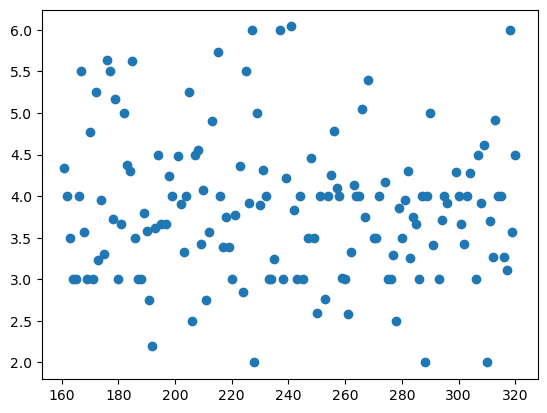

In [113]:
plt.plot(item_age_average.keys(),item_age_average.values(),'o')

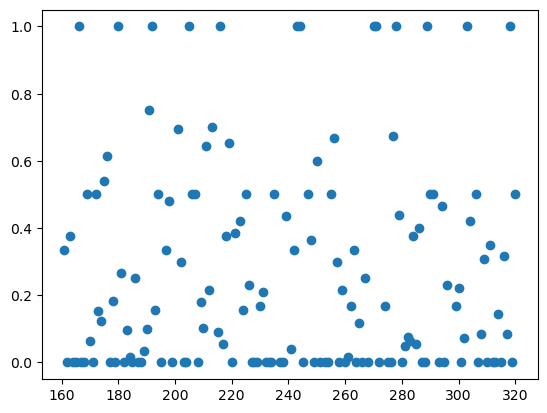

In [114]:
plt.plot(item_gender_average.keys(),item_gender_average.values(),'o')

In [115]:
item_age_avg_column = []
item_gender_avg_column = []
for index, row in df_filtered.iterrows():
    item_age_avg_column.append(round(item_age_average[row['item_id']],2))
    item_gender_avg_column.append(round(item_gender_average[row['item_id']],2))

In [116]:
df_filtered['avg_age'] = item_age_avg_column
df_filtered['avg_gender'] = item_gender_avg_column
df_filtered

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,avg_age,avg_gender
2,109881,230,629,1,1662.0,820,0,4.0,0.0,3.89,0.17
3,109881,230,629,1,1662.0,820,0,4.0,0.0,3.89,0.17
4,109881,230,629,1,1662.0,820,0,4.0,0.0,3.89,0.17
5,142526,193,656,2781,6885.0,1111,0,6.0,0.0,3.61,0.16
6,123526,304,559,3989,3650.0,620,0,5.0,1.0,4.28,0.42
...,...,...,...,...,...,...,...,...,...,...,...
6543,199553,175,1181,4760,247.0,1031,0,5.0,0.0,3.31,0.54
6544,73105,259,614,637,2603.0,1111,0,2.0,0.0,3.02,0.22
6545,403421,175,1181,4760,247.0,1111,0,3.0,1.0,3.31,0.54
6546,116738,186,267,1200,2276.0,1110,0,2.0,1.0,3.50,0.25


In [117]:
user_log = pd.read_csv('../data_format1/use_data/train_format1[161-320].csv')
repeat = user_log.loc[user_log['label'] == 1]
repeat.head()

,user_id,merchant_id,label
2,134532,3323,1
9,87972,4760,1
17,88275,3828,1
24,283392,3323,1
40,227925,4282,1


In [118]:
repeat_user_ids = repeat['user_id'].to_numpy()
repeat_merchant_ids = repeat['merchant_id'].to_numpy()
repeat_transactions = df_filtered.loc[df_filtered['user_id'].isin(repeat_user_ids) & df_filtered['seller_id'].isin(repeat_merchant_ids)]
repeat_transactions

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,avg_age,avg_gender
272,68225,279,898,3323,683.0,1108,0,5.0,1.0,3.86,0.44
1319,5524,224,614,4955,7924.0,1111,0,3.0,0.0,2.84,0.16
2487,88275,170,1095,3828,1446.0,528,0,4.0,0.0,4.77,0.07
2542,55784,281,1130,246,5380.0,1111,0,4.0,0.0,3.95,0.05
3136,177770,279,898,3323,683.0,1110,0,3.0,1.0,3.86,0.44
3137,177770,279,898,3323,683.0,1110,0,3.0,1.0,3.86,0.44
3138,177770,279,898,3323,683.0,1111,0,3.0,1.0,3.86,0.44
3139,177770,279,898,3323,683.0,1107,0,3.0,1.0,3.86,0.44
3255,227925,277,1023,4282,7989.0,627,0,3.0,0.0,3.29,0.67
3844,79189,277,1023,4282,7892.0,801,0,3.0,1.0,3.29,0.67


In [119]:
repeat_transactions_gender = {}
for i in range(0,2):
    repeat_transactions_gender[i] = repeat_transactions.loc[repeat_transactions['gender'] == i].shape[0]
    
repeat_transactions_age = {}
for i in range(0,9):
    repeat_transactions_age[i] = repeat_transactions.loc[repeat_transactions['age_range'] == i].shape[0]
    
repeat_transactions_gender_chance = {}
for key in repeat_transactions_gender:
    repeat_transactions_gender_chance[key] = round(repeat_transactions_gender[key]/sum(repeat_transactions_gender.values()),2)
    
repeat_transactions_age_chance = {}
for key in repeat_transactions_age:
    repeat_transactions_age_chance[key] = round(repeat_transactions_age[key]/sum(repeat_transactions_age.values()),2)
    
print(repeat_transactions_gender_chance)
print(repeat_transactions_age_chance)

{0: 0.27, 1: 0.73}
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.73, 4: 0.23, 5: 0.05, 6: 0.0, 7: 0.0, 8: 0.0}


In [120]:
repeat_chance_gender_column = []
repeat_chance_age_column = []
for index, row in df_filtered.iterrows():
    repeat_chance_gender_column.append(repeat_transactions_gender_chance[row['gender']])
    repeat_chance_age_column.append(repeat_transactions_age_chance[row['age_range']])
df_filtered['% repeat gender'] = repeat_chance_gender_column
df_filtered['% repeat age'] = repeat_chance_age_column
df_filtered

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,avg_age,avg_gender,% repeat gender,% repeat age
2,109881,230,629,1,1662.0,820,0,4.0,0.0,3.89,0.17,0.27,0.23
3,109881,230,629,1,1662.0,820,0,4.0,0.0,3.89,0.17,0.27,0.23
4,109881,230,629,1,1662.0,820,0,4.0,0.0,3.89,0.17,0.27,0.23
5,142526,193,656,2781,6885.0,1111,0,6.0,0.0,3.61,0.16,0.27,0.00
6,123526,304,559,3989,3650.0,620,0,5.0,1.0,4.28,0.42,0.73,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6543,199553,175,1181,4760,247.0,1031,0,5.0,0.0,3.31,0.54,0.27,0.05
6544,73105,259,614,637,2603.0,1111,0,2.0,0.0,3.02,0.22,0.27,0.00
6545,403421,175,1181,4760,247.0,1111,0,3.0,1.0,3.31,0.54,0.73,0.73
6546,116738,186,267,1200,2276.0,1110,0,2.0,1.0,3.50,0.25,0.73,0.00


In [121]:
'''
RECAP
avg_age: average age for that item id
avg_gender: average gender for that item id
% repeat age: Percentage chance that user will be a repeat buyer by their age
% repeat gender: Percentage chance that user will be a repeat buyer by their gender
'''

'\nRECAP\navg_age: average age for that item id\navg_gender: average gender for that item id\n% repeat age: Percentage chance that user will be a repeat buyer by their age\n% repeat gender: Percentage chance that user will be a repeat buyer by their gender\n'

In [122]:
df_age_gender = df_filtered.iloc[:,7:]
df_age_gender

,age_range,gender,avg_age,avg_gender,% repeat gender,% repeat age
2,4.0,0.0,3.89,0.17,0.27,0.23
3,4.0,0.0,3.89,0.17,0.27,0.23
4,4.0,0.0,3.89,0.17,0.27,0.23
5,6.0,0.0,3.61,0.16,0.27,0.00
6,5.0,1.0,4.28,0.42,0.73,0.05
...,...,...,...,...,...,...
6543,5.0,0.0,3.31,0.54,0.27,0.05
6544,2.0,0.0,3.02,0.22,0.27,0.00
6545,3.0,1.0,3.31,0.54,0.73,0.73
6546,2.0,1.0,3.50,0.25,0.73,0.00


In [127]:
pca = PCA(n_components=2)
pca.fit(df_age_gender)

PCA(n_components=2)

In [128]:
print(pca.explained_variance_ratio_)

[0.7458737  0.11511615]


In [129]:
print(pca.singular_values_)

[100.08311867  39.31844255]


In [130]:
#Classifiers

In [137]:
df = pd.read_csv("../data_format1/full_data/train_format1.csv")

In [141]:
train, test = train_test_split(df, test_size=0.2)
print(train)

        user_id  merchant_id  label
96431    360604         2856      0
8690     148377         2791      0
65457    369729         1943      0
115202     9427         3153      0
146267   325423         1399      0
...         ...          ...    ...
95014     85399         4408      0
8258     194712         2422      1
101410   418474         4173      0
69559    314445         1647      0
104701   196276         4542      1

[208691 rows x 3 columns]


In [142]:
X_train = train.drop(['label'], axis=1)
X_train

,user_id,merchant_id
96431,360604,2856
8690,148377,2791
65457,369729,1943
115202,9427,3153
146267,325423,1399
...,...,...
95014,85399,4408
8258,194712,2422
101410,418474,4173
69559,314445,1647


In [143]:
y_train = train['label']
y_train

96431     0
8690      0
65457     0
115202    0
146267    0
         ..
95014     0
8258      1
101410    0
69559     0
104701    1
Name: label, Length: 208691, dtype: int64

In [144]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [145]:
X_test = test.drop(['label'], axis=1)
y_test = test['label']

In [146]:
y_pred = gnb.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 52173 points : 3271


In [147]:
test_df = pd.read_csv("../data_format1/full_data/test_format1.csv")

In [148]:
X_test = test_df.drop(['prob'], axis=1)
X_test


,user_id,merchant_id
0,163968,4605
1,360576,1581
2,98688,1964
3,98688,3645
4,295296,3361
...,...,...
261472,228479,3111
261473,97919,2341
261474,97919,3971
261475,32639,3536


In [149]:
y_test = test_df['prob']
y_test

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
261472   NaN
261473   NaN
261474   NaN
261475   NaN
261476   NaN
Name: prob, Length: 261477, dtype: float64

In [150]:
y_pred = gnb.predict(X_train)
print("Number of mislabeled points out of a total %d points : %d" % (X_train.shape[0], (y_train != y_pred).sum()))

Number of mislabeled points out of a total 208691 points : 12681


In [151]:
train_df_full = pd.read_csv("../data_format1/full_data/train_format1.csv")
train_df = pd.read_csv("../data_format1/use_data/train_format1[161-320].csv")
#same number of samples when merging with full or subset dataset
merged = pd.read_csv("../data_format1/use_data/merged_dataset.csv")

#only pick those in merged whose ["user_id", "seller_id"] match with ["user_id", "merchant_id"] in the train_format1 document
training_key = train_df.loc[:, ["user_id", "merchant_id", "label"]] 
training_set = merged.merge(
        training_key, 
        how="inner", 
        left_on=["user_id", "seller_id"], 
        right_on=["user_id", "merchant_id"]
)

In [152]:
training_set

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,merchant_id,label
0,379824,198,656,145,3462.0,1111,0,5.0,1.0,145,0
1,379824,198,656,145,3462.0,1111,0,5.0,1.0,145,0
2,379824,198,656,145,3462.0,1111,2,5.0,1.0,145,0
3,379824,198,656,145,3462.0,1110,0,5.0,1.0,145,0
4,379824,198,656,145,3462.0,1110,0,5.0,1.0,145,0
...,...,...,...,...,...,...,...,...,...,...,...
380,122632,175,1181,4760,247.0,1109,0,3.0,0.0,4760,0
381,122632,175,1181,4760,247.0,1108,0,3.0,0.0,4760,0
382,122632,175,1181,4760,247.0,1108,0,3.0,0.0,4760,0
383,95362,253,962,3263,626.0,1111,0,0.0,0.0,3263,0


In [153]:
merged_train, merged_test = train_test_split(training_set, test_size=0.2)

In [154]:
Xt_merge = merged_train.drop(['label'], axis=1)
yt_merge = merged_train['label']
print(Xt_merge)


     user_id  item_id  cat_id  seller_id  brand_id  time_stamp  action_type  \
127   291453      274     611       3593     777.0        1111            0   
349   148970      279     898       3323     683.0         522            0   
72    210578      279     898       3323     683.0        1111            0   
90     46699      175    1181       4760     247.0        1109            0   
78    101110      281    1130        246    5380.0        1111            0   
..       ...      ...     ...        ...       ...         ...          ...   
305   175206      175    1181       4760     247.0        1111            0   
173   327782      211    1188       2277    1246.0        1105            0   
382   122632      175    1181       4760     247.0        1108            0   
101   238412      253     962       3263     626.0        1111            0   
12    141307      175    1181       4760     247.0        1111            2   

     age_range  gender  merchant_id  
127        4.

In [155]:
print(yt_merge)

127    0
349    1
72     0
90     0
78     0
      ..
305    0
173    0
382    0
101    0
12     0
Name: label, Length: 308, dtype: int64


In [156]:
mergedGNB = GaussianNB()
mergedGNB.fit(Xt_merge, yt_merge)

GaussianNB()

In [157]:
Xtest_merge = merged_test.drop(['label'], axis=1)
ytest_merge = merged_test['label']

In [158]:
Xtest_merge

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,merchant_id
321,289430,312,602,4129,5491.0,1022,0,7.0,0.0,4129
20,206032,281,1130,246,5380.0,1104,0,4.0,0.0,246
339,125558,279,898,3323,683.0,1111,0,4.0,0.0,3323
84,205257,279,898,3323,683.0,1111,0,6.0,0.0,3323
79,149798,224,614,4955,7924.0,1108,0,2.0,0.0,4955
...,...,...,...,...,...,...,...,...,...,...
244,165262,279,898,3323,683.0,1110,0,0.0,0.0,3323
123,254609,279,898,3323,683.0,1111,0,3.0,0.0,3323
172,327782,211,1188,2277,1246.0,1105,0,3.0,1.0,2277
5,379824,198,656,145,3462.0,1110,0,5.0,1.0,145


In [159]:
ytest_merge

321    0
20     0
339    0
84     0
79     0
      ..
244    0
123    0
172    0
5      0
176    0
Name: label, Length: 77, dtype: int64

In [160]:
merged_pred = gnb.predict(Xtest_merge)
print("Number of mislabeled points out of a total %d points : %d" % (Xtest_merge.shape[0], (ytest_merge != merged_pred).sum()))

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- action_type
- age_range
- brand_id
- cat_id
- gender
- ...
Feature names must be in the same order as they were in fit.



ValueError: X has 10 features, but GaussianNB is expecting 2 features as input.

In [161]:
#NN Classifiers

In [162]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

In [163]:
train_df_full = pd.read_csv("../data_format1/full_data/train_format1.csv")
train_df = pd.read_csv("../data_format1/use_data/train_format1[161-320].csv")
#same number of samples when merging with full or subset dataset
merged = pd.read_csv("../data_format1/use_data/merged_dataset.csv")

#only pick those in merged whose ["user_id", "seller_id"] match with ["user_id", "merchant_id"] in the train_format1 document
training_key = train_df.loc[:, ["user_id", "merchant_id", "label"]] 
training_set = merged.merge(
        training_key, 
        how="inner", 
        left_on=["user_id", "seller_id"], 
        right_on=["user_id", "merchant_id"]
)

In [164]:
training_set.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,merchant_id,label
0,379824,198,656,145,3462.0,1111,0,5.0,1.0,145,0
1,379824,198,656,145,3462.0,1111,0,5.0,1.0,145,0
2,379824,198,656,145,3462.0,1111,2,5.0,1.0,145,0
3,379824,198,656,145,3462.0,1110,0,5.0,1.0,145,0
4,379824,198,656,145,3462.0,1110,0,5.0,1.0,145,0


In [165]:
train, test = train_test_split(training_set, test_size=0.2)

In [166]:
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(train.shape[1]-1,) ))        #label kept getting counted as a feature
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc'])

In [167]:
history = model.fit(train.drop(['label'], axis=1), train['label'],
                    epochs=20,
                    #batch_size=
                    )

Epoch 1/20
10/10 [==============================] - 1s 2ms/step - loss: 172.5551 - acc: 0.8701
Epoch 2/20
10/10 [==============================] - 0s 2ms/step - loss: 135.2921 - acc: 0.7922
Epoch 3/20
10/10 [==============================] - 0s 2ms/step - loss: 128.0199 - acc: 0.8474
Epoch 4/20
10/10 [==============================] - 0s 3ms/step - loss: 118.3691 - acc: 0.8182
Epoch 5/20
10/10 [==============================] - 0s 3ms/step - loss: 115.8307 - acc: 0.8052
Epoch 6/20
10/10 [==============================] - 0s 2ms/step - loss: 108.8739 - acc: 0.8312
Epoch 7/20
10/10 [==============================] - 0s 3ms/step - loss: 109.6609 - acc: 0.8182
Epoch 8/20
10/10 [==============================] - 0s 1ms/step - loss: 107.6797 - acc: 0.8474
Epoch 9/20
10/10 [==============================] - 0s 2ms/step - loss: 100.3219 - acc: 0.8084
Epoch 10/20
10/10 [==============================] - 0s 2ms/step - loss: 101.3118 - acc: 0.8377
Epoch 11/20
10/10 [==============================

In [168]:
model.evaluate(test.drop(['label'], axis=1), test['label'],)

3/3 [==============================] - 0s 2ms/step - loss: 45.2271 - acc: 0.8442


[45.22712707519531, 0.8441558480262756]